# Conor Sayres
# Astro 507
# Homework 1

## 1a)

The code is implemented in C++ using pybind11 as a Python wrapper.  I chose C++ to allow me to experiment with small timesteps and large ensembles of particles while minimizing computation time. To build, type: 

```python setup.py build```

at the terminal to create the Python-importable module **cParticle**.

### File Descriptions:

**setup.py** - script to build the code

**cParticle.cpp** - Python bindings for the C++ Box class (simulator).

**particles.h** - C++ header.  Shows available classes, attributes and methods with some description.

**particles.cpp** - Implements the simulation routines.

### Code Description:

CGS units are used throughout the code. I model particles in a 2 dimensional box with reflecting edges. Particles are specified by the following initial conditions: mass, radius, x position, y position, x velocity, y velocity.  A box is defined by a width, height, and random seed. The Box Class provides a method for easily adding particles with random positions and directions at a specified velocity.  When a particle's position is within a radius of a wall, the velocity component normal to the wall is inverted. Reflections are tracked throughout the simulation to monitor pressure. Particles interact with one another via 2D elastic collisions. A collision is flagged by the following criteria:

1) The spacing between particles is less than or equal to the sum of the particles' radii.

2) The distance between particles is decreasing with time.

Enforcing criterion 2) improves the simulation results.  This protects against issues related to the time-stepping nature of the routine in which a collision may have recently occured and begun spatially separating, but not yet to the extent satisfying criterion 1) by the next time step.  Collision detection code is implemented in the Box::isCollided method.  Collision instances are modeled elastically.  To accomplish this I used the recipe specified here: 

https://en.wikipedia.org/wiki/Elastic_collision#Two-dimensional_collision_with_two_moving_objects

These equations are implemented in the Box::handleCollision method, which modifies the velocities of two particles experiencing a collision. The simulation itself proceeds as following:

1) Specify number of iterations (steps), and associated timestep (dt), and a rate at which to save the simulation state (saveEvery)

2) Begin loop over steps

3) At each step, modify all particles' positions forward in time (eg, x = x + vx*dt)

4) Reflect velocities for those particles at a boundary at this step

5) Check for collisions among all pairs of particles

6) For those particles collided, exchange momentum and energy elastically

7) Save the current state of the simulation (at specified frequency) for analysis later.

Here is a demonstration of a simulation of two particles in a box with unequal masses (progress during simulation is printed to terminal running the notebook):

In [1]:
from cParticle import Box

width = 100
height = 100
mass = 1
radius = 10
velocity = width / 5
seed = 0
steps = 10000
dt = 0.001 * radius / velocity
saveEvery = 1000

box = Box(width, height, seed)
box.addRandomParticle(mass, radius, velocity)
box.addRandomParticle(10*mass, radius, velocity)
box.runSim(steps, dt, saveEvery)

The script ***movie2body.py*** will create a movie of the simulation (one example here): https://github.com/csayres/astro507/blob/master/hw1/twoParticles.mp4).  

### 1b)
The following function will plot a snapshot of particle positions and speed distribution for a given simulation:

In [2]:
import numpy
from shapely.geometry import Point
from descartes import PolygonPatch
import matplotlib.pyplot as plt

def plotOne(box, step):
    """Input instance of box (after sim), desired step to plot
    """
    fig = plt.figure(figsize=(6,8))
    ax1 = plt.subplot2grid((4,3), (0,0), rowspan=3, colspan=3)
    ax2 = plt.subplot2grid((4,3), (3,0), colspan=3)
    for ii, particle in enumerate(box.particleSteps[step]):
        topcolor="blue"
        # index 2 is x, 3 is y, 1 is radius.
        pt = Point(particle[2], particle[3]).buffer(particle[1], cap_style=1)
        patch = PolygonPatch(pt, fc=topcolor)
        ax1.add_patch(patch)
    ax1.set_ylim([0, height])
    ax1.set_xlim([0, width])

    # plot histogram of speeds
    speeds = [x[4] for x in box.particleSteps[step]]
    bins = numpy.linspace(0,numpy.max(speeds)*1.1,50)
    ax2.hist(speeds, bins=bins)
    ax2.set_xlim([0, numpy.max(speeds)*1.1])
    ax2.set_xlabel("speed (cm/s)")
    plt.show()

Set up the simulation:

In [3]:
width = 100
height = 100
seed = 10
mass = 1
velocity = width / 10
radius = 0.02 * width # 2 percent the box size
nParticles = 100
dt = 0.05 * radius / velocity
steps = 10000
saveEvery = 100

box = Box(width, height, seed)
# add particles to the box
for ii in range(nParticles):
    box.addRandomParticle(mass, radius, velocity)
    
# run the simulation
box.runSim(steps, dt, saveEvery)

Plot initial state:

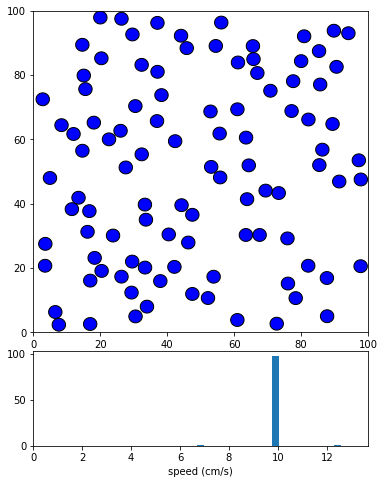

In [4]:
plotOne(box, 0)

Plot final state:

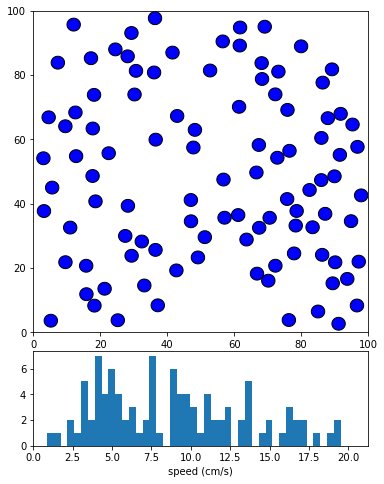

In [5]:
plotOne(box, -1)

### 2a) See work handed in...

### 2b)

For this, I ramped up the total number of particles and the particle density.  Plots are generated below using information stored in the Box.particleSteps attribute.  This takes several minutes to complete on my machine.


In [6]:
k_b = 1.380648e-16 # erg/K
width = 100*2 # bigger box
seed = 0
height = 100*2
radius = 2
mass = 1
nParticles = 400*4 # more particles
v = width / 10 # velocity
ke = 0.5 * mass * v**2 # kinetic energy of particle at start of simulation
T = ke / k_b

# run the simulation:
box = Box(width, height, seed)
for ii in range(nParticles):
    box.addRandomParticle(mass, radius, v)
steps = 10000
dt = 0.02 * radius / v
saveEvery = 1
box.runSim(steps, dt, saveEvery)

Plot results:

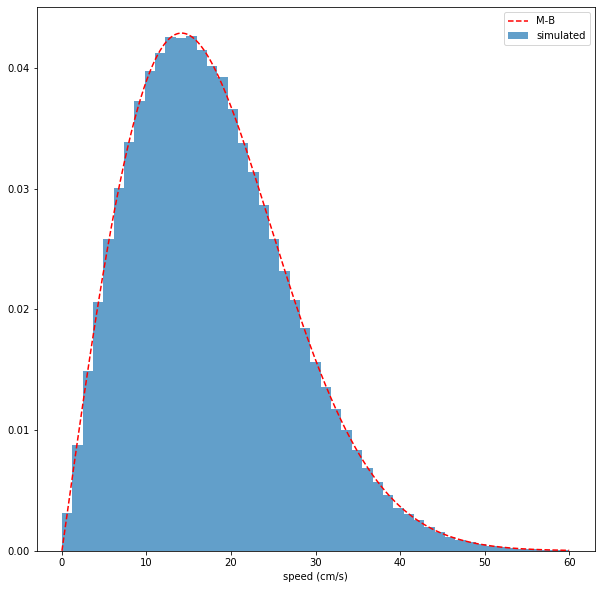

In [7]:
def plotMB(box):
    # plot the velocity distribution of particles in the box
    # overlay the 2D velocity maxwellian.
    
    # particleSteps is nSteps x nParticles x [mass, radius, x, y, speed]
    # take only results after 600 steps (assume the system has relaxed)
    relaxed = numpy.asarray(box.particleSteps[600:])
    # just keep the speed information
    speeds = relaxed[:,:,4].flatten()

    # plot a normalized histogram of speeds
    bins = numpy.linspace(0,3*v,50)
    plt.figure(figsize=(10,10))
    plt.hist(speeds, bins=bins, density=True, alpha=0.7, label="simulated")

    # construct the M-B distribution, numerically integrate
    # to obtain a sufficient normalization
    vs = numpy.linspace(0, 3*v, 10000)
    p = mass * vs / (k_b * T) * numpy.exp(-1 * mass * vs**2 / (2 * k_b * T))
    dv = numpy.diff(vs)[0]
    pSum = numpy.sum(p) * dv
    plt.plot(vs, p/pSum, '--r', label="M-B")
    plt.xlabel("speed (cm/s)")
    plt.legend()
    plt.show()

plotMB(box)

### 2c)

This time make half of the particles ten times as massive and plot results

In [8]:
# update kinetic energy and T to reflect the modifications of masses
ke = 0.5 * 5.5 * mass * v**2 # now average mass is 5.5 (half at 1 half at 10)
T = ke / k_b

# run the simulation
box = Box(width, height, seed)
for ii in range(nParticles):
    # make every even particle 10x the mass
    if ii % 2 == 0:
        box.addRandomParticle(10*mass, radius, v)
    else:
        box.addRandomParticle(mass, radius, v)

box.runSim(steps, dt, saveEvery)

Plot the results of the mixed-mass simulation:

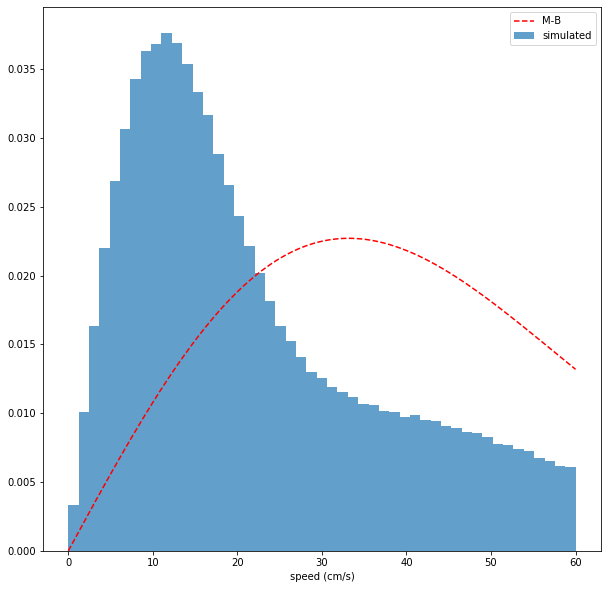

In [9]:
plotMB(box)

The velocity distribution definitely doesn't follow a single Maxwellian, at a glance, it may be the superposition of two Maxwellians.  The dotted red line traces the expected Maxwellian given the kinetic energy input.  The deviation is due to the presence of unequal species in the ensemble. Lets plot the energy distribution next:

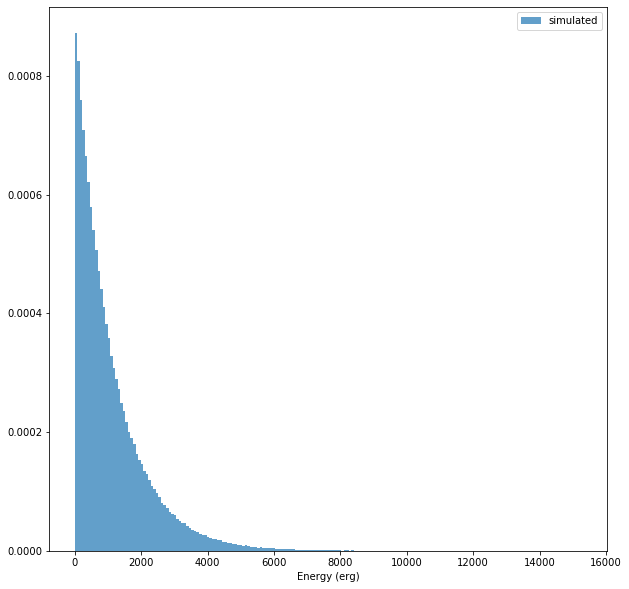

In [10]:
def plotMB_E(box):
    # plots the energy distribution rather than the velocity distribution
    
    # particleSteps is nSteps x nParticles x [mass, radius, x, y, speed]
    # take only results after 600 steps (assume the system has relaxed)
    relaxed = numpy.asarray(box.particleSteps[600:])
    # calculate energy 0.5 * m * v**2
    E = (0.5*relaxed[:,:,0]*relaxed[:,:,4]**2).flatten()
    
    plt.figure(figsize=(10,10))
    plt.hist(E, bins=200, density=True, alpha=0.7, label="simulated")
    plt.xlabel("Energy (erg)")
    plt.legend()
    plt.show()


plotMB_E(box)

The energy distribution decays exponentially, as derived in 2a).

### 3a)

Invent a numerical criterion to determine when the system has relaxed.  Lets do two simulations varying the particle radius, and inspect the resulting distributions.  The rationale is that at smaller radii, particles collide less frequently, and thus will take longer to relax.

In [11]:
k_b = 1.380648e-16 # erg/K
width = 100*2
height = 100*2
radius = 2
mass = 1
# nParticles = 400*4
nParticles = 1000
v = width / 10
ke = 0.5 * mass * v**2
T = ke / k_b
dt = 0.002 * radius / v
steps = 10000
seed = 0
saveEvery = 1

# box1 large radius
box_bigrad = Box(width, height, seed)
for ii in range(nParticles):
    box_bigrad.addRandomParticle(mass, radius, v)
box_bigrad.runSim(steps, dt, saveEvery)

box_smallrad = Box(width, height, seed)
for ii in range(nParticles):
    box_smallrad.addRandomParticle(mass, radius/2, v)
box_smallrad.runSim(steps, dt, saveEvery)



Pick a roboust statistic (innner quartile range) to apply to the velocity distribution as a function of time.  A robost statistic is useful because we are dealing with a generally noisy distribution and don't want to be greatly effected by outliers.

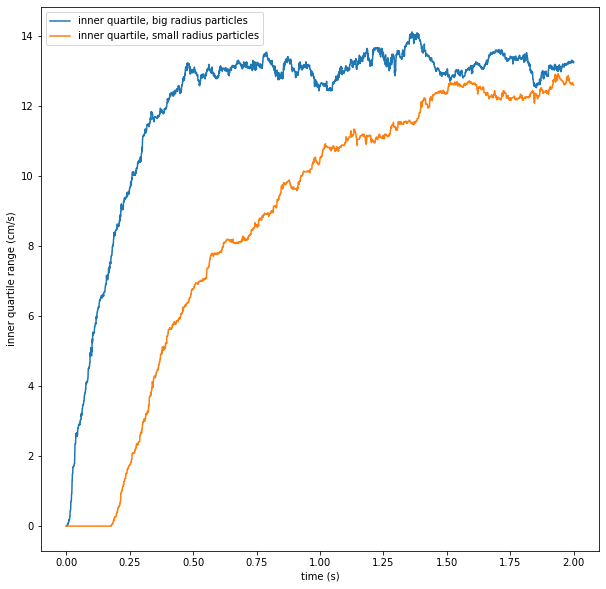

In [12]:
from scipy.stats import iqr

# compute innerquartile speed range for big radius particles at each timestep
speeds_big = numpy.array(box_bigrad.particleSteps)[:,:,4] # 4 index is speed
iqr_big = iqr(speeds_big,axis=1) # compute the inner quartile range for each step

# compute innerquartile speed range for little radius particles at each timestep
speeds_small = numpy.array(box_smallrad.particleSteps)[:,:,4] # 4 index is speed
iqr_small = iqr(speeds_small, axis=1)

plt.figure(figsize=(10,10))
plt.plot(numpy.arange(steps)*dt, iqr_big, label="inner quartile, big radius particles")
plt.plot(numpy.arange(steps)*dt, iqr_small, label="inner quartile, small radius particles")
plt.xlabel("time (s)")
plt.ylabel("inner quartile range (cm/s)")
plt.legend()
plt.show()

When the curve above flattens (inner quartile range stabilizes), let's assume this indicates that system has relaxed.  To compute the relaxation time, we'll analyze the differentials of the curves above.

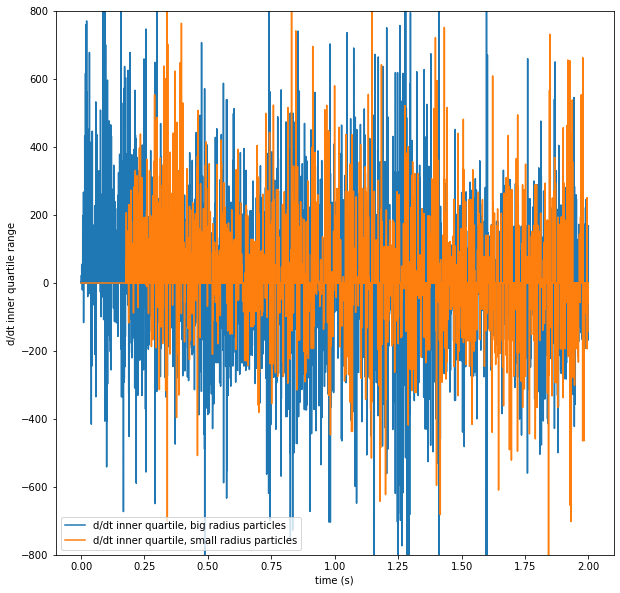

In [13]:
# numerically differentiate
dIqr_big = numpy.diff(iqr_big)/dt
dIqr_small = numpy.diff(iqr_small)/dt
ts = (numpy.arange(steps)*dt)[:-1] # timesteps for differential

plt.figure(figsize=(10,10))
plt.plot(ts, dIqr_big, label="d/dt inner quartile, big radius particles")
plt.plot(ts, dIqr_small, label="d/dt inner quartile, small radius particles")
plt.xlabel("time (s)")
plt.ylabel("d/dt inner quartile range")
plt.ylim([-800,800])
plt.legend()
plt.show()

As expected the blue (bigger radii particles) converge (relax) to zero before the orange (smaller radii partilcles).  Build an esitmator to decide when relaxation is achieved.  First, smooth the signal over many steps to beat down noise.

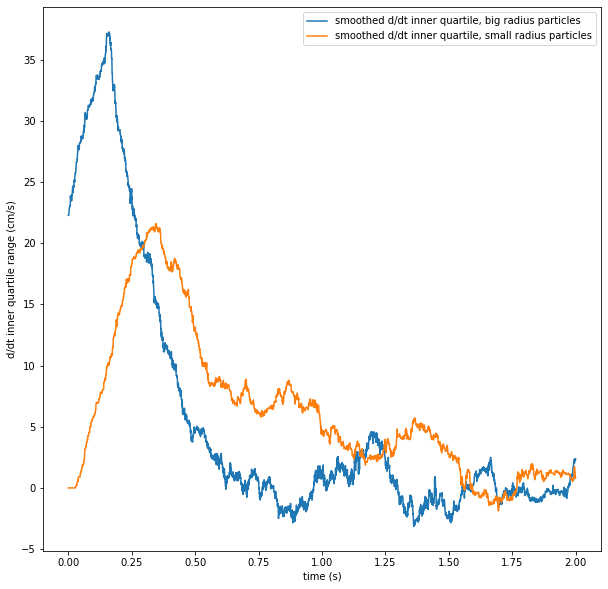

In [14]:
smoothPoints = 1500

def smooth(y, box_pts):
    # https://stackoverflow.com/questions/20618804/how-to-smooth-a-curve-in-the-right-way
    box = numpy.ones(box_pts)/box_pts
    y_smooth = numpy.convolve(y, box, mode='same')
    return y_smooth

dIqr_big_smooth = smooth(dIqr_big, smoothPoints)
dIqr_small_smooth = smooth(dIqr_small, smoothPoints)

plt.figure(figsize=(10,10))
plt.plot(ts, dIqr_big_smooth, label="smoothed d/dt inner quartile, big radius particles")
plt.plot(ts, dIqr_small_smooth, label="smoothed d/dt inner quartile, small radius particles")
plt.xlabel("time (s)")
plt.ylabel("d/dt inner quartile range (cm/s)")
plt.legend()
plt.show()

The resulting curves are much smoother, but suffer a lead-in ramp due to the convolution, and probably a time lag due to the moving average effect.  Nevertheless determine the time at which convergence happens (when the smooth line crosses 0).  Ignore the lead-in effect of the smoother by tossing out the points near time = 0.  Below is a function that returns the relaxation time based on the inner quartile range statistic.

In [15]:
def measureRelaxTime(particleSteps, dt):
    """ Return the time at which the simulation has relaxed, based on the (smoothed) rate of chance
    of the inner quartile range of the speed distribution crosses zero.
    """
    steps = len(particleSteps)
    smoothPoints = 1000
    speeds = numpy.array(particleSteps)[:,:,4]
    iqRange = iqr(speeds, axis=1)
    dIqr = numpy.diff(iqRange)/dt
    dIqr_smooth = smooth(dIqr, smoothPoints)
    # find the index at which rate of change of innerquartile range of the 
    # velocity distribution crosses 0
    # ignore the first smoothPoints
    i = numpy.argwhere(dIqr_smooth[smoothPoints:] < 0)[0][0]
    # determine the time of that event.
    t = (((numpy.arange(steps)*dt)[:-1])[smoothPoints:])[i]
    
    return t

### 3b)

Relaxation happens when particles exchange energy and momentum with eachother. I'll estimate the system is relaxed after 3 collisions per particle on average.  The average particle collision count $N$ can be estimated given a particle's 1D cross section $\sigma$, the particle's speed $v$, the 2D number density $n$, and the time $t$:

$$
N = \sigma v n t
$$

setting $N=3$ and soving for $t$ we can derive a relaxation time:

$$
t = 3 / (\sigma v n)
$$

In [16]:
# a function to calculate relaxation time
def computeRelaxTime(radius, velocity, particleDensity):
    return 3 / (2*radius*velocity*particleDensity)

### 3c)
Let's see if this time scales with my numerical (inner quartile range) statstic for determining the relaxation time.  First generate a grid  of simulations varying both radius and particle number.  For each parameter setting I run several random trials so I can average the results between them.

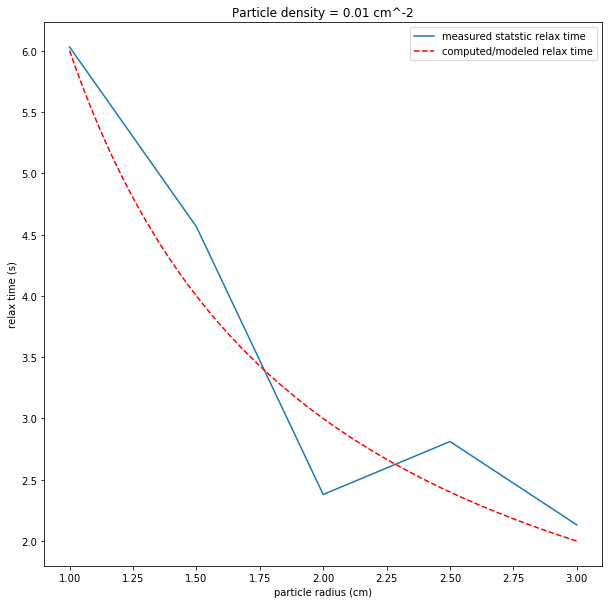

In [17]:
import time
from multiprocessing import Pool
# fix number of particles at 500, and velocity at 20
# look at relaxation time as a function of radii
# average over trials (seeds) at each grid point
# use multiprocessing to speed up simulations at each seed

width = 200
height = 200
dt = 0.002
steps = 5000
velocity = 20
particles = 500
density = particles/(width*height)
saveEvery = 1
mass = 1
radiusList = numpy.linspace(1, 3, 5)
nSeeds = 7
seeds = range(nSeeds)
measuredTimes = []
for radius in radiusList:
    # average over nSeeds trials at each radius
    def runSim(seed):
        # function for using multiprocessing
        box = Box(height, width, seed)
        for particle in range(particles):
            box.addRandomParticle(mass, radius, velocity)
        box.runSim(steps, dt, saveEvery)
        return box.particleSteps
    
    p = Pool(nSeeds)
    simOutputs = p.map(runSim, seeds)
    p.close()
    # combine results from all sims
    particleSteps = simOutputs[0]
    for seed in range(1,nSeeds):
        ps = simOutputs[seed]
        for ii, particleStep in enumerate(ps):
            particleSteps[ii] += particleStep # append to array at each timestep
  
    tRelax = measureRelaxTime(particleSteps, dt)
    measuredTimes.append(tRelax)
        
    
plt.figure(figsize=(10,10))
# # plot the measured relax times
plt.plot(radiusList, measuredTimes, label="measured statstic relax time")
# # plot a computed curve of relax times
radii = numpy.linspace(radiusList[0], radiusList[-1], 100)
plt.plot(radii, computeRelaxTime(radii, velocity, density), "--r", label="computed/modeled relax time")
plt.xlabel("particle radius (cm)")
plt.ylabel("relax time (s)")
plt.title("Particle density = %.2f cm^-2"%(particles/(height*width)))
plt.legend()
plt.show()
        
    

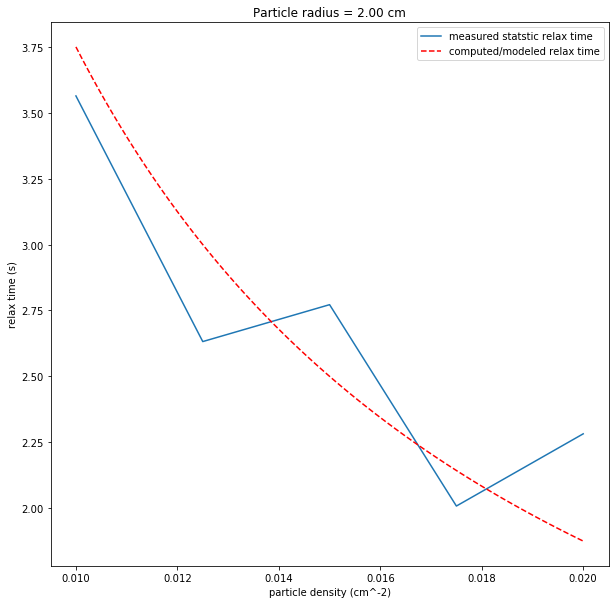

In [18]:
import time
# fix radius at 2 and velocity at 20
# look at relaxation time as a function of particle density
# average over nSeeds trials at each grid point
width = 200
height = 200
dt = 0.002
steps = 5000
velocity = 20
saveEvery = 1
mass = 1
radius = 2
measuredTimes = []
particlesList = numpy.array([400, 500, 600, 700, 800])
densities = particlesList / (width*height)
for particles in particlesList:
    # average over nSeeds trials at each particle count
    
    def runSim(seed):
        # function for using multiprocessing
        box = Box(height, width, seed)
        for particle in range(particles):
            box.addRandomParticle(mass, radius, velocity)
        box.runSim(steps, dt, saveEvery)
        return box.particleSteps
    
    p = Pool(nSeeds)
    simOutputs = p.map(runSim, seeds)
    p.close()
    
    particleSteps = simOutputs[0]
    for seed in range(1,nSeeds):
        ps = simOutputs[seed]
        for ii, particleStep in enumerate(ps):
            particleSteps[ii] += particleStep # append to array at each timestep
  
    tRelax = measureRelaxTime(particleSteps, dt)
    measuredTimes.append(tRelax)
        
    
plt.figure(figsize=(10,10))
# # plot the measured relax times
plt.plot(densities, measuredTimes, label="measured statstic relax time")
# # plot a computed curve of relax times
dd = numpy.linspace(densities[0], densities[-1], 100)
plt.plot(dd, computeRelaxTime(radius, velocity, dd), "--r", label="computed/modeled relax time")
plt.xlabel("particle density (cm^-2)")
plt.ylabel("relax time (s)")
plt.title("Particle radius = %.2f cm"%(radius))
plt.legend()
plt.show()
        
    

In [19]:
numpy.array(measuredTimes).shape


(5,)

### 4)

Show $P = n k T$  

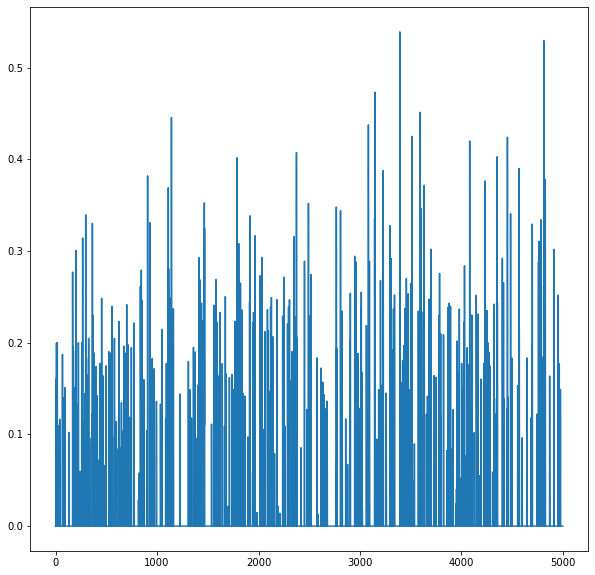

In [20]:
from cParticle import Box
width = 200
height = 200
dt = 0.001
steps = 5000
velocities = [14, 16, 18, 20, 22]
particles = 500
saveEvery = 1
mass = 1
radius = 2
seed = 0

box = Box(height, width, seed)
for particle in range(particles):
    box.addRandomParticle(mass, radius, velocity)
box.runSim(steps, dt, saveEvery)

plt.figure(figsize=(10,10))
plt.plot(range(steps), box.pressureSteps)
plt.show()



